<a href="https://colab.research.google.com/github/Frodo-Swaggins/COMP702PROJECT/blob/main/comp703project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

START OF PREPROCESSING

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#imports and creating the path to the images
import os
import cv2
cv2.__version__
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join

mypath = '/content/drive/MyDrive/RandNotes'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

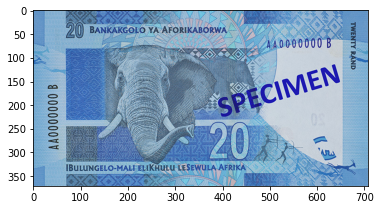

In [4]:
#Opening the images and loading them as image objects into an array using open cv
images = []
count = 0

for fil in onlyfiles:
  imagepath = '/content/drive/MyDrive/RandNotes/' + fil
  image = cv2.imread(imagepath)
  images.append(image)

plt.imshow(images[0])

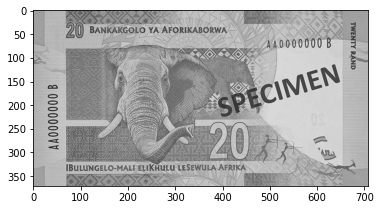

In [5]:
#grayscale conversion on the array of images
grays = []
for image in images:
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grays.append(gray)
plt.imshow(grays[0], cmap = 'gray')

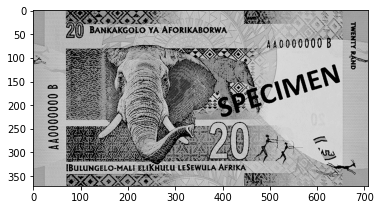

In [6]:
#Thresholding of the array of images
binary = []
for gray in grays:
  blurred = cv2.GaussianBlur(gray, (7, 7), 0)
  ret, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
  ret, thresh2 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
  ret, thresh3 = cv2.threshold(gray, 120, 255, cv2.THRESH_TRUNC)
  ret, thresh4 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO)
  ret, thresh5 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO_INV)
  ret, thresh6 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  adaptiveThresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
 
  binary.append(thresh4)
plt.imshow(binary[0], cmap = 'gray')

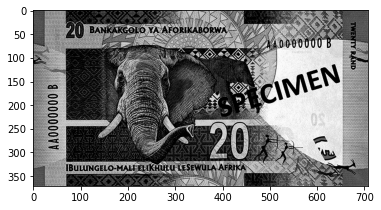

In [7]:
#Histogram normalisation of the therholded array of images
equ = []

for bin in binary:
  equalised = cv2.equalizeHist(bin)
  equ.append(equalised)

plt.imshow(equ[0], cmap = 'gray')

100


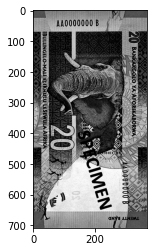

In [8]:
#Data augmentation is performed on the equalised images
#We take the first half (0-25) of the images and rotate them 90 degrees clockwise
#We take the second half (26-49) of the images and rotate them 90 degrees counterclockwise
#We do this to increase the size of our dataset
preprocessed = []
for i in range (len(equ)):
  if(i<=25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_CLOCKWISE))
  if(i<=49 and i>25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.imshow(preprocessed[1], cmap = 'gray')
print(len(preprocessed))

END OF PREPROCESSING

ENHANCEMENT

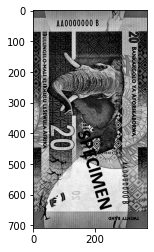

In [9]:
#Enhancement code
hist=[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for pp in preprocessed:
  hist.append(clahe.apply(pp))

plt.imshow(hist[1], cmap = 'gray')

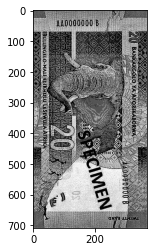

In [10]:
#Sharpening
sharp=[]
for h in hist:
  sharp.append(cv2.filter2D(src=h,ddepth=0,kernel=np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])))

plt.imshow(sharp[1],cmap='gray')

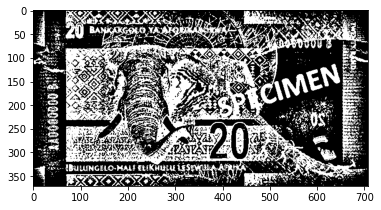

In [23]:
#Segmentation
from scipy import optimize,signal

def Adap_th_mean(img , kernel_size, method = "bin_inv"):
    I = img.copy()
    if (kernel_size % 2) == 0:  # check if the size is even
        kernel_size += 1  # if it does -> make odd. by +1 we more % of the signal
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
    t = signal.convolve2d(I,kernel, mode='same')
    if method == "bin":
        I[I <= t] = 0
    if method =="bin_inv":
        I[I > t] = 0
    I[I > 0] = 255
    return I

def kernel_Gauss(kernel_size,sigma): #creates gaussian kernel with given size, and std (sigma)
    ax = np.linspace(- (kernel_size-1) / 2,  (kernel_size-1) / 2,  kernel_size)
    xx, yy = np.meshgrid(ax,ax)
    kernel = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(np.square(xx) + np.square(yy)) / (2 * (sigma ** 2)))
    return kernel / kernel.sum()

def Adap_th_gauss(img , kernel_size, method = "bin_inv"):
    I = img.copy()
    sigma = 0.3*((kernel_size-1)*0.5 - 1) + 0.8
    if (kernel_size % 2) == 0:  # check if the size is even
        kernel_size += 1  # if it does -> make odd. by +1 we more % of the signal
    kernel = kernel_Gauss(kernel_size,sigma)
    t = signal.convolve2d(I,kernel, mode='same')
    if method == "bin":
        I[I <= t] = 0
    if method =="bin_inv":
        I[I > t] = 0
    I[I > 0] = 255
    return I

segmented = []

for num_of_im in range(1):
    img_samp = sharp[num_of_im]
    img_samp = cv2.GaussianBlur(img_samp ,(3,3),cv2.BORDER_DEFAULT) #apply some smoothing
    thh_inv = Adap_th_mean(img_samp , 109, method = "bin_inv")
    thh_inv_g = Adap_th_gauss(img_samp,109, method = "bin_inv")
    segmented.append(thh_inv)
    #plt.imshow(thh_inv_g,cmap='gray')

plt.imshow(segmented[0],cmap='gray')

https://developpaper.com/simple-implementation-of-region-growing-in-python/ - Source used for segmentation code

FEATURE EXTRACTION

In [22]:
import math
# Hu moment features extracted from segmented images
Hu_moment_features = []
for i in segmented:
  im = i
  # Calculate Moments
  moments = cv2.moments(im)
  # Calculate Hu Moments
  huMoments = cv2.HuMoments(moments)
  # Log scale hu moments
  for i in range(0,7):
    huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
  # Append features vector to array of feature vectors
  Hu_moment_features.append(huMoments)

print(Hu_moment_features)


[array([[ -2.21257772],
       [ -4.38563044],
       [ -7.32686621],
       [ -7.31403856],
       [-14.63449048],
       [ -9.50682439],
       [-11.79811582]]), array([[-1.17826336],
       [-2.27450376],
       [-4.8705867 ],
       [-4.86460546],
       [-9.7321173 ],
       [-6.0018386 ],
       [ 8.02654683]]), array([[ -2.11236337],
       [ -4.2158796 ],
       [ -5.68122523],
       [ -5.71835916],
       [-11.41814718],
       [ -7.82629652],
       [ -9.05996449]]), array([[-0.4054037 ],
       [-0.61215192],
       [-2.58476371],
       [-2.58364714],
       [-5.16785038],
       [-2.88274053],
       [-2.66999567]]), array([[ 0.28621885],
       [ 1.31657014],
       [ 1.77958584],
       [ 2.5168078 ],
       [-4.67009261],
       [-3.27960721],
       [-5.48264745]]), array([[-0.85170052],
       [-1.66581842],
       [-3.12771957],
       [-3.12199586],
       [-6.24685338],
       [-3.95473887],
       [-3.21035122]]), array([[ 0.03304963],
       [ 0.94881723],
     